# Evaluation and Comparison of Boosted ML Models in Behavior-Based Malware Detection


## Notebook: CatBoost Training

***

**What is the objective of this file?**

To train the model using the Train Split (Statically Split).

## Checklist

- Ensure that you have the proper dataset files that you intend to use (i.e., whether the lite dataset or full version). 
    - The datasets it will use points to `/Official Development/Dataset/IB` & `/Official Development/Dataset/TB`. 
    - You can run the `/Official Development/Dataset [OFFICIAL] Oliveira Dataset Notebook.ipynb file` or unzip one of the zipped folders in the `/Official Development/Dataset/Processed` towards the two aforementioned folders. 
- Ensure that you have installed the necessary libraries needed to execute the training process. 
    - You can view the list of the specific versions in the thesis document or through the `.sh` or `.bat` files in the repository's home directory.

# 1. CatB Training Setup

Setting training environment parameters.

## 1.0. Tuning Settings

1. What will the output filename be?
2. Will you train a tuned model?
3. What hyperparameter values will you use?

For no. 3, the value looks like
`{'task_type': 'CPU', 'objective': 'Logloss', 'n_estimators': 50, 'max_depth': 11, 'learning_rate': 0.1, 'l2_leaf_reg': 2, 'grow_policy': 'SymmetricTree', 'bootstrap_type': 'Bayesian', 'boosting_type': 'Ordered', 'auto_class_weights': 'Balanced'}`
which is obtained as part of the results of the associated tuning file to this file.

Alternatively, you can just point a file directly to it (overrides the manual setup if not empty).

**Do not include the custom hyperparameter values for `random_state`, `thread_count`, `verbose`, `cat_features`, and `nan_mode` as the values for these are hardcoded to the notebook.**

In [1]:
MODEL_FILENAME = "RYZEN2b" # <== Set the prefix for the filename of the output file (don't include file extension)
TUNED_TRAINING = False # <== Set as True if you'll be training a tuned model.

# These parameters are mostly default valued parameters for CatBoost except some that are mentioned in the paper (e.g., Ordered Boosting, Symmeteric Tree); Set as None for truly defaults.
TB_HYPERPARAMS = None # None or like "{'task_type': 'CPU', 'objective':'Logloss', 'grow_policy': 'SymmetricTree', 'bootstrap_type': 'Bayesian', 'boosting_type': 'Ordered'}"
IB_HYPERPARAMS = None # None or like "{'task_type': 'CPU', 'objective':'Logloss', 'grow_policy': 'SymmetricTree', 'bootstrap_type': 'Bayesian', 'boosting_type': 'Ordered'}"

TB_HYPERPARAMS_FILE = "./Outputs/Results/Ryzen2_NoFalse/CatB Tuning/RYZEN2_CATB_TB.tune" # <== Empty string or Pointing a .tune file overrides the value set above.
IB_HYPERPARAMS_FILE = "./Outputs/Results/Ryzen2_NoFalse/CatB Tuning/RYZEN2_CATB_IB.tune" # <== Empty string or Pointing a .tune file overrides the value set above.

STATIC_SPLIT = 0.3 # <== To achieve the 70:30 Static Split
RANDOM_SEED = 1 # <== Must be the same throughout the entire study (acts as a controlled variable), hence let's just settle with 1.

# ⚠️Warning

**Be careful of modifying the code beyond this point as it was designed to run autonomously based on the parameters set above.**

## 1.1. Loading Libraries

In [2]:
#Python Libraries
import time
from datetime import datetime
import json

#Data/Dataset Libraries
import pandas as pd
import numpy as np

#Model Selection
from sklearn.model_selection import train_test_split

#Metrics (for in-training testing only)
from sklearn.metrics import classification_report, accuracy_score, balanced_accuracy_score, f1_score
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay
from sklearn.metrics import precision_score, recall_score, roc_auc_score

#Visualization
from matplotlib import pyplot as plt

#GBDT Models
# import lightgbm
import catboost

#File Writing Library (exclusive for use on LightGBM)
from joblib import dump, load

## 1.2. Logging and Diagnostics

In [3]:
if TUNED_TRAINING:
    MODEL_FILENAME = "TUNED_" + MODEL_FILENAME
    if len(TB_HYPERPARAMS_FILE) != 0:
        f = open(TB_HYPERPARAMS_FILE, "r")
        TB_HYPERPARAMS = f.readline()
        f.close()
    if len(IB_HYPERPARAMS_FILE) != 0:
        f = open(IB_HYPERPARAMS_FILE, "r")
        IB_HYPERPARAMS = f.readline()
        f.close()
    TB_HYPERPARAMS = TB_HYPERPARAMS.replace('\'', '\"')#.replace("False", "\"False\"").replace("True", "\"True\"")
    TB_HYPERPARAMS = json.loads(str(TB_HYPERPARAMS))
    print("Parsed TB Hyperparams:", TB_HYPERPARAMS)
    print("")
    IB_HYPERPARAMS = IB_HYPERPARAMS.replace('\'', '\"')#.replace("False", "\"False\"").replace("True", "\"True\"")
    IB_HYPERPARAMS = json.loads(str(IB_HYPERPARAMS))
    print("Parsed IB Hyperparams:", IB_HYPERPARAMS)
else:
    if TB_HYPERPARAMS != None:
        TB_HYPERPARAMS = TB_HYPERPARAMS.replace('\'', '\"').replace("False", "\"False\"").replace("True", "\"True\"")
        TB_HYPERPARAMS = json.loads(str(TB_HYPERPARAMS))
    else:
        TB_HYPERPARAMS = None
    if IB_HYPERPARAMS != None:
        IB_HYPERPARAMS = IB_HYPERPARAMS.replace('\'', '\"').replace("False", "\"False\"").replace("True", "\"True\"")
        IB_HYPERPARAMS = json.loads(str(IB_HYPERPARAMS))
    else:
        IB_HYPERPARAMS = None

start = end = 0
LOG_FILENAME = "CATB_Training_Log.txt"
def logging(message):
    log = open(LOG_FILENAME, "a")
    log.write(message)
    log.close()
def start_time():
    global start
    start = time.time()
def end_time(process):
    global start
    elapse = time.time()-start
    start = 0
    printout = f"{str(datetime.now())}@{MODEL_FILENAME}: {process} - {round(elapse, 6)}s\n"
    logging(printout)
    return round(elapse, 6)

## 1.3. Loading Datasets

Note that it will use the files in `/Official Development/Dataset/IB` & `/Official Development/Dataset/TB`. 

### 1.3.1. Setting filenames

In [4]:
#Setting filenames of files
TB_Train = "../Dataset/TB/CATB_TB.csv" # <== Location for Time-based Train Split for CatBoost
#TB_Test = "../Dataset/TB/TB_Test_CATB.csv" # <== Location for Time-based Test Split for CatBoost
IB_Train = "../Dataset/IB/CATB_IB.csv" # <== Location for Instance-based Train Split for CatBoost
#IB_Test = "../Dataset/IB/IB_Test_CATB.csv" # <== Location for Instance-based Test Split for CatBoost

### 1.3.2. Loading datasets to DataFrames

In [5]:
#Loading datasets to DataFrames
tb_train = pd.read_csv(TB_Train, low_memory=False).fillna("NaN")
ib_train = pd.read_csv(IB_Train, low_memory=False).fillna("NaN")

print("Dataset Sizes")
print("TB Train Size:", tb_train.shape)
print("IB Train Size:", ib_train.shape)

Dataset Sizes
TB Train Size: (72298, 101)
IB Train Size: (72298, 101)


### 1.3.3. Previewing datasets

In [6]:
#Previewing Time-based Dataset
tb_train.head()

,malware,t_0,t_1,t_2,t_3,t_4,t_5,t_6,t_7,t_8,...,t_90,t_91,t_92,t_93,t_94,t_95,t_96,t_97,t_98,t_99
0,1,RegOpenKeyExA,NtOpenKey,NtQueryValueKey,NtClose,NtOpenKey,NtQueryValueKey,NtClose,NtQueryAttributesFile,LoadStringA,...,LdrGetProcedureAddress,GetSystemWindowsDirectoryW,NtCreateFile,NtCreateSection,NtMapViewOfSection,NtClose,GetSystemMetrics,NtAllocateVirtualMemory,CreateActCtxW,GetSystemWindowsDirectoryW
1,1,GetSystemTimeAsFileTime,LdrLoadDll,LdrGetProcedureAddress,LdrLoadDll,LdrGetProcedureAddress,LdrLoadDll,LdrGetProcedureAddress,LdrLoadDll,LdrGetProcedureAddress,...,RegQueryInfoKeyW,RegEnumKeyExW,RegOpenKeyExW,RegQueryValueExW,RegOpenKeyExW,RegQueryValueExW,RegOpenKeyExW,RegQueryValueExW,RegOpenKeyExW,RegQueryValueExW
2,1,GetSystemTimeAsFileTime,NtCreateMutant,GetSystemTimeAsFileTime,NtOpenKeyEx,NtQueryKey,NtOpenKeyEx,LdrLoadDll,LdrGetProcedureAddress,RegOpenKeyExW,...,GetSystemInfo,NtClose,NtUnmapViewOfSection,NtClose,RegOpenKeyExW,RegCloseKey,RegOpenKeyExW,RegQueryValueExW,RegCloseKey,NtOpenFile
3,1,GetSystemTimeAsFileTime,LdrLoadDll,LdrGetProcedureAddress,LdrLoadDll,LdrGetProcedureAddress,LdrLoadDll,LdrGetProcedureAddress,LdrLoadDll,LdrGetProcedureAddress,...,RegQueryValueExW,RegOpenKeyExW,RegQueryValueExW,RegOpenKeyExW,RegQueryValueExW,RegOpenKeyExW,RegQueryValueExW,RegOpenKeyExW,RegQueryValueExW,RegOpenKeyExW
4,1,SetErrorMode,OleInitialize,LdrGetDllHandle,LdrLoadDll,LdrGetProcedureAddress,LdrLoadDll,LdrGetProcedureAddress,LdrLoadDll,LdrGetProcedureAddress,...,RegOpenKeyExW,RegQueryValueExW,RegCloseKey,NtCreateMutant,GetNativeSystemInfo,GetSystemWindowsDirectoryW,NtClose,LdrLoadDll,LdrGetProcedureAddress,LdrLoadDll


In [7]:
#Previewing Instance-based Dataset
ib_train.head()

,malware,t_0,t_1,t_2,t_3,t_4,t_5,t_6,t_7,t_8,...,t_90,t_91,t_92,t_93,t_94,t_95,t_96,t_97,t_98,t_99
0,1,RegOpenKeyExA,NtOpenKey,NtQueryValueKey,NtClose,NtQueryAttributesFile,LoadStringA,NtAllocateVirtualMemory,LdrGetDllHandle,LdrGetProcedureAddress,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,1,GetSystemTimeAsFileTime,LdrLoadDll,LdrGetProcedureAddress,LdrGetDllHandle,SetUnhandledExceptionFilter,CryptAcquireContextW,NtOpenKey,NtQueryValueKey,NtClose,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2,1,GetSystemTimeAsFileTime,NtCreateMutant,NtOpenKeyEx,NtQueryKey,LdrLoadDll,LdrGetProcedureAddress,RegOpenKeyExW,RegQueryInfoKeyW,RegEnumKeyExW,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3,1,GetSystemTimeAsFileTime,LdrLoadDll,LdrGetProcedureAddress,LdrGetDllHandle,SetUnhandledExceptionFilter,CryptAcquireContextW,NtOpenKey,NtQueryValueKey,NtClose,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
4,1,SetErrorMode,OleInitialize,LdrGetDllHandle,LdrLoadDll,LdrGetProcedureAddress,NtOpenSection,NtMapViewOfSection,RegOpenKeyExW,RegQueryValueExW,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


### 1.3.4. Statically Splitting the Train Split

Train Split --> Training and Validation Split

However only Training Split will be used.

In [8]:
#Static splitting of Train Split of Time-based
X_tb = tb_train.iloc[:,1:101] #All rows, 2nd to last column
y_tb = tb_train.iloc[:,0] #All rows, first column only
X_tb_training, X_tb_validate, y_tb_training, y_tb_validate = train_test_split(X_tb, y_tb, test_size=STATIC_SPLIT, shuffle=True, random_state=1)

#Static splitting of Train Split of Instance-based
X_ib = ib_train.iloc[:,1:101] #All rows, 2nd to last column
y_ib = ib_train.iloc[:,0] #All rows, first column only
X_ib_training, X_ib_validate, y_ib_training, y_ib_validate = train_test_split(X_ib, y_ib, test_size=STATIC_SPLIT, shuffle=True, random_state=1)

# 2. Model Training

## 2.1. Setting up the Model

In [9]:
def get_indexes():
    indexes = []
    for i in range(100):
        indexes.append(f"t_{i}")
    return indexes

def setup_model(HYPERPARAMS, TYPE):
    global TUNED_TRAINING
    indexes = get_indexes()
    metric=['Logloss', 'AUC', 'Precision']
    train_dir = f"Outputs/CATB/{MODEL_FILENAME}_CATB_{TYPE}_TRAINDIR"
    if HYPERPARAMS == None:
        return catboost.CatBoostClassifier(random_state=RANDOM_SEED, thread_count=-1, verbose=1, cat_features=indexes, 
                                           nan_mode='Min', custom_metric=metric, train_dir=train_dir, one_hot_max_size=256)
    return catboost.CatBoostClassifier(**HYPERPARAMS, random_state=RANDOM_SEED, thread_count=-1, verbose=1, cat_features=indexes, 
                                       nan_mode='Min', custom_metric=metric, train_dir=train_dir, one_hot_max_size=256)

## 2.2. Training on Time-Based Behaviors

### 2.2.1 Training Model

In [10]:
#Training Model
start_time()
tb_catb = setup_model(TB_HYPERPARAMS, "TB")
tb_catb.fit(X_tb_training, y_tb_training, plot=True, eval_set=catboost.Pool(X_tb_validate, label=y_tb_validate, cat_features=get_indexes()), save_snapshot=True, snapshot_interval=60)
end_time("CATB_TB")

#Saving Model as file
tb_catb.save_model("Outputs/CATB/"+MODEL_FILENAME+"_CATB_TB.model", format="json")

MetricVisualizer(layout=Layout(align_self='stretch', height='500px'))

Learning rate set to 0.083532
0:	learn: 0.5231294	test: 0.5236079	best: 0.5236079 (0)	total: 198ms	remaining: 3m 18s
1:	learn: 0.3939695	test: 0.3944637	best: 0.3944637 (1)	total: 241ms	remaining: 2m
2:	learn: 0.2944701	test: 0.2949217	best: 0.2949217 (2)	total: 281ms	remaining: 1m 33s
3:	learn: 0.2133831	test: 0.2138856	best: 0.2138856 (3)	total: 327ms	remaining: 1m 21s
4:	learn: 0.1739618	test: 0.1747859	best: 0.1747859 (4)	total: 365ms	remaining: 1m 12s
5:	learn: 0.1427340	test: 0.1436188	best: 0.1436188 (5)	total: 408ms	remaining: 1m 7s
6:	learn: 0.1142342	test: 0.1151712	best: 0.1151712 (6)	total: 471ms	remaining: 1m 6s
7:	learn: 0.0929540	test: 0.0939708	best: 0.0939708 (7)	total: 517ms	remaining: 1m 4s
8:	learn: 0.0799514	test: 0.0810683	best: 0.0810683 (8)	total: 560ms	remaining: 1m 1s
9:	learn: 0.0689049	test: 0.0701744	best: 0.0701744 (9)	total: 608ms	remaining: 1m
10:	learn: 0.0624155	test: 0.0639065	best: 0.0639065 (10)	total: 648ms	remaining: 58.3s
11:	learn: 0.0577505	tes

98:	learn: 0.0227828	test: 0.0286309	best: 0.0286309 (98)	total: 3.49s	remaining: 31.7s
99:	learn: 0.0227501	test: 0.0286137	best: 0.0286137 (99)	total: 3.52s	remaining: 31.6s
100:	learn: 0.0225306	test: 0.0284997	best: 0.0284997 (100)	total: 3.55s	remaining: 31.6s
101:	learn: 0.0225061	test: 0.0284971	best: 0.0284971 (101)	total: 3.57s	remaining: 31.5s
102:	learn: 0.0224607	test: 0.0284178	best: 0.0284178 (102)	total: 3.6s	remaining: 31.4s
103:	learn: 0.0224361	test: 0.0284139	best: 0.0284139 (103)	total: 3.63s	remaining: 31.3s
104:	learn: 0.0224105	test: 0.0284026	best: 0.0284026 (104)	total: 3.66s	remaining: 31.2s
105:	learn: 0.0223853	test: 0.0283846	best: 0.0283846 (105)	total: 3.69s	remaining: 31.1s
106:	learn: 0.0221675	test: 0.0282007	best: 0.0282007 (106)	total: 3.72s	remaining: 31.1s
107:	learn: 0.0220584	test: 0.0281383	best: 0.0281383 (107)	total: 3.76s	remaining: 31s
108:	learn: 0.0220248	test: 0.0281126	best: 0.0281126 (108)	total: 3.79s	remaining: 31s
109:	learn: 0.02199

196:	learn: 0.0176816	test: 0.0252152	best: 0.0252152 (196)	total: 6.37s	remaining: 26s
197:	learn: 0.0176663	test: 0.0251962	best: 0.0251962 (197)	total: 6.4s	remaining: 25.9s
198:	learn: 0.0175990	test: 0.0251610	best: 0.0251610 (198)	total: 6.44s	remaining: 25.9s
199:	learn: 0.0175848	test: 0.0251600	best: 0.0251600 (199)	total: 6.47s	remaining: 25.9s
200:	learn: 0.0175221	test: 0.0251029	best: 0.0251029 (200)	total: 6.49s	remaining: 25.8s
201:	learn: 0.0174976	test: 0.0250971	best: 0.0250971 (201)	total: 6.52s	remaining: 25.8s
202:	learn: 0.0174838	test: 0.0250868	best: 0.0250868 (202)	total: 6.54s	remaining: 25.7s
203:	learn: 0.0174626	test: 0.0250808	best: 0.0250808 (203)	total: 6.57s	remaining: 25.6s
204:	learn: 0.0173270	test: 0.0250221	best: 0.0250221 (204)	total: 6.62s	remaining: 25.7s
205:	learn: 0.0172574	test: 0.0249908	best: 0.0249908 (205)	total: 6.65s	remaining: 25.6s
206:	learn: 0.0171442	test: 0.0249101	best: 0.0249101 (206)	total: 6.68s	remaining: 25.6s
207:	learn: 0

290:	learn: 0.0135936	test: 0.0228318	best: 0.0228318 (290)	total: 9.25s	remaining: 22.5s
291:	learn: 0.0135851	test: 0.0228326	best: 0.0228318 (290)	total: 9.29s	remaining: 22.5s
292:	learn: 0.0135059	test: 0.0227536	best: 0.0227536 (292)	total: 9.34s	remaining: 22.5s
293:	learn: 0.0134649	test: 0.0227411	best: 0.0227411 (293)	total: 9.37s	remaining: 22.5s
294:	learn: 0.0134565	test: 0.0227394	best: 0.0227394 (294)	total: 9.42s	remaining: 22.5s
295:	learn: 0.0134449	test: 0.0227381	best: 0.0227381 (295)	total: 9.45s	remaining: 22.5s
296:	learn: 0.0134128	test: 0.0226823	best: 0.0226823 (296)	total: 9.5s	remaining: 22.5s
297:	learn: 0.0133924	test: 0.0226758	best: 0.0226758 (297)	total: 9.53s	remaining: 22.5s
298:	learn: 0.0133726	test: 0.0226714	best: 0.0226714 (298)	total: 9.57s	remaining: 22.4s
299:	learn: 0.0133645	test: 0.0226645	best: 0.0226645 (299)	total: 9.61s	remaining: 22.4s
300:	learn: 0.0133510	test: 0.0226601	best: 0.0226601 (300)	total: 9.65s	remaining: 22.4s
301:	learn:

385:	learn: 0.0110031	test: 0.0212239	best: 0.0212239 (385)	total: 12.6s	remaining: 20.1s
386:	learn: 0.0109446	test: 0.0211842	best: 0.0211842 (386)	total: 12.7s	remaining: 20.1s
387:	learn: 0.0109108	test: 0.0211784	best: 0.0211784 (387)	total: 12.7s	remaining: 20s
388:	learn: 0.0109051	test: 0.0211760	best: 0.0211760 (388)	total: 12.7s	remaining: 20s
389:	learn: 0.0108928	test: 0.0211746	best: 0.0211746 (389)	total: 12.8s	remaining: 20s
390:	learn: 0.0108499	test: 0.0211610	best: 0.0211610 (390)	total: 12.8s	remaining: 19.9s
391:	learn: 0.0108396	test: 0.0211627	best: 0.0211610 (390)	total: 12.8s	remaining: 19.9s
392:	learn: 0.0108196	test: 0.0211620	best: 0.0211610 (390)	total: 12.8s	remaining: 19.8s
393:	learn: 0.0107696	test: 0.0211467	best: 0.0211467 (393)	total: 12.9s	remaining: 19.8s
394:	learn: 0.0107639	test: 0.0211381	best: 0.0211381 (394)	total: 12.9s	remaining: 19.8s
395:	learn: 0.0107511	test: 0.0211337	best: 0.0211337 (395)	total: 12.9s	remaining: 19.7s
396:	learn: 0.01

481:	learn: 0.0101436	test: 0.0207528	best: 0.0207528 (424)	total: 15.5s	remaining: 16.7s
482:	learn: 0.0101436	test: 0.0207528	best: 0.0207528 (424)	total: 15.6s	remaining: 16.6s
483:	learn: 0.0101436	test: 0.0207528	best: 0.0207528 (424)	total: 15.6s	remaining: 16.6s
484:	learn: 0.0101436	test: 0.0207528	best: 0.0207528 (424)	total: 15.6s	remaining: 16.6s
485:	learn: 0.0101436	test: 0.0207528	best: 0.0207528 (424)	total: 15.7s	remaining: 16.6s
486:	learn: 0.0101436	test: 0.0207528	best: 0.0207528 (424)	total: 15.7s	remaining: 16.5s
487:	learn: 0.0101436	test: 0.0207528	best: 0.0207528 (424)	total: 15.7s	remaining: 16.5s
488:	learn: 0.0101436	test: 0.0207528	best: 0.0207528 (424)	total: 15.8s	remaining: 16.5s
489:	learn: 0.0101436	test: 0.0207528	best: 0.0207528 (424)	total: 15.8s	remaining: 16.5s
490:	learn: 0.0101436	test: 0.0207528	best: 0.0207528 (424)	total: 15.8s	remaining: 16.4s
491:	learn: 0.0101436	test: 0.0207528	best: 0.0207528 (424)	total: 15.9s	remaining: 16.4s
492:	learn

577:	learn: 0.0101436	test: 0.0207528	best: 0.0207528 (424)	total: 18.4s	remaining: 13.4s
578:	learn: 0.0101436	test: 0.0207528	best: 0.0207528 (424)	total: 18.4s	remaining: 13.4s
579:	learn: 0.0101436	test: 0.0207528	best: 0.0207528 (424)	total: 18.5s	remaining: 13.4s
580:	learn: 0.0101436	test: 0.0207528	best: 0.0207528 (424)	total: 18.5s	remaining: 13.3s
581:	learn: 0.0101436	test: 0.0207528	best: 0.0207528 (424)	total: 18.6s	remaining: 13.3s
582:	learn: 0.0101436	test: 0.0207528	best: 0.0207528 (424)	total: 18.6s	remaining: 13.3s
583:	learn: 0.0101436	test: 0.0207528	best: 0.0207528 (424)	total: 18.6s	remaining: 13.3s
584:	learn: 0.0101436	test: 0.0207528	best: 0.0207528 (424)	total: 18.7s	remaining: 13.2s
585:	learn: 0.0101436	test: 0.0207528	best: 0.0207528 (424)	total: 18.7s	remaining: 13.2s
586:	learn: 0.0101436	test: 0.0207528	best: 0.0207528 (424)	total: 18.7s	remaining: 13.2s
587:	learn: 0.0101436	test: 0.0207528	best: 0.0207528 (424)	total: 18.8s	remaining: 13.1s
588:	learn

671:	learn: 0.0101436	test: 0.0207528	best: 0.0207528 (424)	total: 21.3s	remaining: 10.4s
672:	learn: 0.0101436	test: 0.0207528	best: 0.0207528 (424)	total: 21.3s	remaining: 10.3s
673:	learn: 0.0101436	test: 0.0207528	best: 0.0207528 (424)	total: 21.3s	remaining: 10.3s
674:	learn: 0.0101436	test: 0.0207528	best: 0.0207528 (424)	total: 21.4s	remaining: 10.3s
675:	learn: 0.0101436	test: 0.0207528	best: 0.0207528 (424)	total: 21.4s	remaining: 10.2s
676:	learn: 0.0101436	test: 0.0207528	best: 0.0207528 (424)	total: 21.4s	remaining: 10.2s
677:	learn: 0.0101436	test: 0.0207528	best: 0.0207528 (424)	total: 21.4s	remaining: 10.2s
678:	learn: 0.0101436	test: 0.0207528	best: 0.0207528 (424)	total: 21.5s	remaining: 10.1s
679:	learn: 0.0101436	test: 0.0207528	best: 0.0207528 (424)	total: 21.5s	remaining: 10.1s
680:	learn: 0.0101436	test: 0.0207528	best: 0.0207528 (424)	total: 21.5s	remaining: 10.1s
681:	learn: 0.0101436	test: 0.0207528	best: 0.0207528 (424)	total: 21.5s	remaining: 10s
682:	learn: 

769:	learn: 0.0101436	test: 0.0207528	best: 0.0207528 (424)	total: 23.9s	remaining: 7.15s
770:	learn: 0.0101436	test: 0.0207528	best: 0.0207528 (424)	total: 24s	remaining: 7.12s
771:	learn: 0.0101436	test: 0.0207528	best: 0.0207528 (424)	total: 24s	remaining: 7.08s
772:	learn: 0.0101436	test: 0.0207528	best: 0.0207528 (424)	total: 24s	remaining: 7.05s
773:	learn: 0.0101436	test: 0.0207528	best: 0.0207528 (424)	total: 24s	remaining: 7.02s
774:	learn: 0.0101436	test: 0.0207528	best: 0.0207528 (424)	total: 24.1s	remaining: 6.98s
775:	learn: 0.0101436	test: 0.0207528	best: 0.0207528 (424)	total: 24.1s	remaining: 6.95s
776:	learn: 0.0101436	test: 0.0207528	best: 0.0207528 (424)	total: 24.1s	remaining: 6.92s
777:	learn: 0.0101436	test: 0.0207528	best: 0.0207528 (424)	total: 24.1s	remaining: 6.88s
778:	learn: 0.0101436	test: 0.0207528	best: 0.0207528 (424)	total: 24.2s	remaining: 6.85s
779:	learn: 0.0101436	test: 0.0207528	best: 0.0207528 (424)	total: 24.2s	remaining: 6.82s
780:	learn: 0.0101

864:	learn: 0.0101436	test: 0.0207528	best: 0.0207528 (424)	total: 26.6s	remaining: 4.14s
865:	learn: 0.0101436	test: 0.0207528	best: 0.0207528 (424)	total: 26.6s	remaining: 4.11s
866:	learn: 0.0101436	test: 0.0207528	best: 0.0207528 (424)	total: 26.6s	remaining: 4.08s
867:	learn: 0.0101436	test: 0.0207528	best: 0.0207528 (424)	total: 26.6s	remaining: 4.05s
868:	learn: 0.0101436	test: 0.0207528	best: 0.0207528 (424)	total: 26.7s	remaining: 4.02s
869:	learn: 0.0101436	test: 0.0207528	best: 0.0207528 (424)	total: 26.7s	remaining: 3.99s
870:	learn: 0.0101436	test: 0.0207528	best: 0.0207528 (424)	total: 26.7s	remaining: 3.96s
871:	learn: 0.0101436	test: 0.0207528	best: 0.0207528 (424)	total: 26.7s	remaining: 3.92s
872:	learn: 0.0101436	test: 0.0207528	best: 0.0207528 (424)	total: 26.8s	remaining: 3.89s
873:	learn: 0.0101436	test: 0.0207528	best: 0.0207528 (424)	total: 26.8s	remaining: 3.86s
874:	learn: 0.0101436	test: 0.0207528	best: 0.0207528 (424)	total: 26.8s	remaining: 3.83s
875:	learn

957:	learn: 0.0101436	test: 0.0207528	best: 0.0207528 (424)	total: 29s	remaining: 1.27s
958:	learn: 0.0101436	test: 0.0207528	best: 0.0207528 (424)	total: 29.1s	remaining: 1.24s
959:	learn: 0.0101436	test: 0.0207528	best: 0.0207528 (424)	total: 29.1s	remaining: 1.21s
960:	learn: 0.0101436	test: 0.0207528	best: 0.0207528 (424)	total: 29.1s	remaining: 1.18s
961:	learn: 0.0101436	test: 0.0207528	best: 0.0207528 (424)	total: 29.1s	remaining: 1.15s
962:	learn: 0.0101436	test: 0.0207528	best: 0.0207528 (424)	total: 29.1s	remaining: 1.12s
963:	learn: 0.0101436	test: 0.0207528	best: 0.0207528 (424)	total: 29.2s	remaining: 1.09s
964:	learn: 0.0101436	test: 0.0207528	best: 0.0207528 (424)	total: 29.2s	remaining: 1.06s
965:	learn: 0.0101436	test: 0.0207528	best: 0.0207528 (424)	total: 29.2s	remaining: 1.03s
966:	learn: 0.0101436	test: 0.0207528	best: 0.0207528 (424)	total: 29.2s	remaining: 998ms
967:	learn: 0.0101436	test: 0.0207528	best: 0.0207528 (424)	total: 29.3s	remaining: 968ms
968:	learn: 

### 2.2.2. Checking Performance

Using the split for validation for a bit of internal checking of performance (i.e., not official)

CATB_TB
              precision    recall  f1-score   support

           0     0.9993    0.9904    0.9949     10842
           1     0.9905    0.9994    0.9949     10848

    accuracy                         0.9949     21690
   macro avg     0.9949    0.9949    0.9949     21690
weighted avg     0.9949    0.9949    0.9949     21690



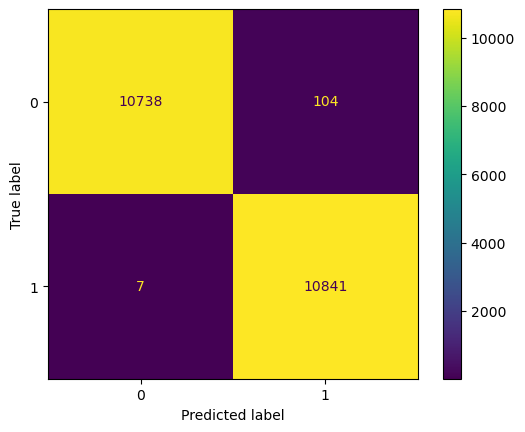

In [11]:
y_pred = tb_catb.predict(X_tb_validate)
print("CATB_TB")
print(classification_report(y_tb_validate, y_pred, digits=4))
print(classification_report(y_tb_validate, y_pred, digits=4), file=open("Outputs/CATB/"+MODEL_FILENAME+"_CATB_TB_ClassReport.txt", mode='w'))
disp = ConfusionMatrixDisplay(confusion_matrix(y_tb_validate, y_pred))
disp.plot()
plt.savefig("Outputs/CATB/"+MODEL_FILENAME+"_CATB_TB_"+"_ConfMatrix.png")

### 2.2.3. Preview of the Tree

*How can it be a tree if there is no proof of a tree?*

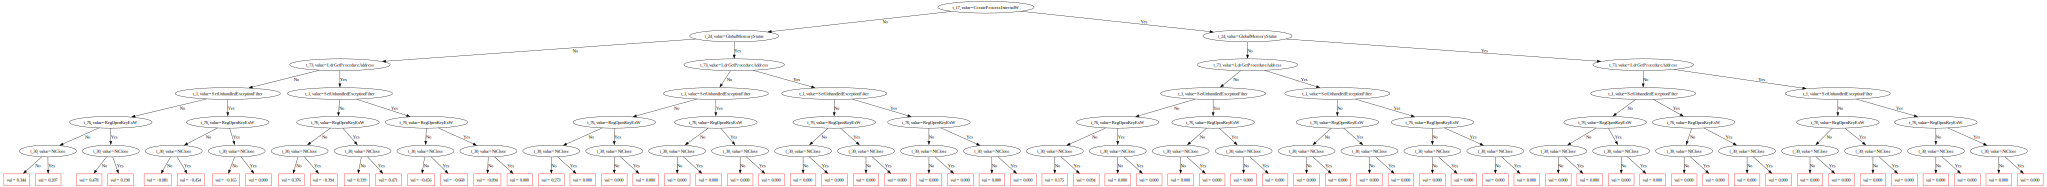

In [12]:
tree = tb_catb.plot_tree(0, catboost.Pool(X_tb_training, y_tb_training, cat_features=get_indexes(), feature_names=list(X_tb_training.columns)))
tree.save("Outputs/CATB/"+MODEL_FILENAME+"_CATB_TREE/TB_Tree"+".svg")
display(tree)

## 2.3. Training on Instance-Based Behaviors

### 2.3.1 Training Model

In [13]:
#Training Model
start_time()
ib_catb = setup_model(IB_HYPERPARAMS, "IB")
ib_catb.fit(X_ib_training, y_ib_training, plot=True, eval_set=catboost.Pool(X_ib_validate, label=y_ib_validate, cat_features=get_indexes()), save_snapshot=True, snapshot_interval=60)
end_time("CATB_IB")

#Saving Model as file
ib_catb.save_model("Outputs/CATB/"+MODEL_FILENAME+"_CATB_IB.model", format="json")

MetricVisualizer(layout=Layout(align_self='stretch', height='500px'))

Learning rate set to 0.083532
0:	learn: 0.5342092	test: 0.5346779	best: 0.5346779 (0)	total: 24.2ms	remaining: 24.1s
1:	learn: 0.3912467	test: 0.3919154	best: 0.3919154 (1)	total: 44.8ms	remaining: 22.4s
2:	learn: 0.2969116	test: 0.2972638	best: 0.2972638 (2)	total: 65ms	remaining: 21.6s
3:	learn: 0.2315717	test: 0.2323334	best: 0.2323334 (3)	total: 85.2ms	remaining: 21.2s
4:	learn: 0.1856561	test: 0.1866744	best: 0.1866744 (4)	total: 106ms	remaining: 21.1s
5:	learn: 0.1517244	test: 0.1528914	best: 0.1528914 (5)	total: 126ms	remaining: 20.9s
6:	learn: 0.1277909	test: 0.1290078	best: 0.1290078 (6)	total: 147ms	remaining: 20.8s
7:	learn: 0.1102311	test: 0.1115369	best: 0.1115369 (7)	total: 167ms	remaining: 20.7s
8:	learn: 0.0980510	test: 0.0994652	best: 0.0994652 (8)	total: 188ms	remaining: 20.7s
9:	learn: 0.0863177	test: 0.0879686	best: 0.0879686 (9)	total: 209ms	remaining: 20.7s
10:	learn: 0.0729704	test: 0.0746957	best: 0.0746957 (10)	total: 229ms	remaining: 20.6s
11:	learn: 0.0633827

101:	learn: 0.0253966	test: 0.0308007	best: 0.0308007 (101)	total: 1.9s	remaining: 16.7s
102:	learn: 0.0253718	test: 0.0307890	best: 0.0307890 (102)	total: 1.92s	remaining: 16.7s
103:	learn: 0.0253497	test: 0.0307891	best: 0.0307890 (102)	total: 1.94s	remaining: 16.7s
104:	learn: 0.0253248	test: 0.0307923	best: 0.0307890 (102)	total: 1.96s	remaining: 16.7s
105:	learn: 0.0253002	test: 0.0307831	best: 0.0307831 (105)	total: 1.97s	remaining: 16.6s
106:	learn: 0.0252784	test: 0.0307643	best: 0.0307643 (106)	total: 1.99s	remaining: 16.6s
107:	learn: 0.0252546	test: 0.0307649	best: 0.0307643 (106)	total: 2.01s	remaining: 16.6s
108:	learn: 0.0252304	test: 0.0307651	best: 0.0307643 (106)	total: 2.02s	remaining: 16.5s
109:	learn: 0.0252076	test: 0.0307630	best: 0.0307630 (109)	total: 2.04s	remaining: 16.5s
110:	learn: 0.0251819	test: 0.0307635	best: 0.0307630 (109)	total: 2.06s	remaining: 16.5s
111:	learn: 0.0251581	test: 0.0307636	best: 0.0307630 (109)	total: 2.07s	remaining: 16.4s
112:	learn:

194:	learn: 0.0200719	test: 0.0275595	best: 0.0275595 (194)	total: 3.6s	remaining: 14.8s
195:	learn: 0.0200591	test: 0.0275583	best: 0.0275583 (195)	total: 3.61s	remaining: 14.8s
196:	learn: 0.0199375	test: 0.0274641	best: 0.0274641 (196)	total: 3.63s	remaining: 14.8s
197:	learn: 0.0198865	test: 0.0274340	best: 0.0274340 (197)	total: 3.65s	remaining: 14.8s
198:	learn: 0.0198738	test: 0.0274349	best: 0.0274340 (197)	total: 3.67s	remaining: 14.8s
199:	learn: 0.0197046	test: 0.0273230	best: 0.0273230 (199)	total: 3.69s	remaining: 14.7s
200:	learn: 0.0196884	test: 0.0273078	best: 0.0273078 (200)	total: 3.7s	remaining: 14.7s
201:	learn: 0.0196244	test: 0.0272521	best: 0.0272521 (201)	total: 3.72s	remaining: 14.7s
202:	learn: 0.0196040	test: 0.0272554	best: 0.0272521 (201)	total: 3.74s	remaining: 14.7s
203:	learn: 0.0195921	test: 0.0272556	best: 0.0272521 (201)	total: 3.75s	remaining: 14.7s
204:	learn: 0.0193920	test: 0.0270782	best: 0.0270782 (204)	total: 3.77s	remaining: 14.6s
205:	learn: 

288:	learn: 0.0156654	test: 0.0246875	best: 0.0246875 (288)	total: 5.3s	remaining: 13s
289:	learn: 0.0156395	test: 0.0246741	best: 0.0246741 (289)	total: 5.32s	remaining: 13s
290:	learn: 0.0156297	test: 0.0246720	best: 0.0246720 (290)	total: 5.33s	remaining: 13s
291:	learn: 0.0156228	test: 0.0246752	best: 0.0246720 (290)	total: 5.35s	remaining: 13s
292:	learn: 0.0155765	test: 0.0246549	best: 0.0246549 (292)	total: 5.37s	remaining: 13s
293:	learn: 0.0155686	test: 0.0246480	best: 0.0246480 (293)	total: 5.39s	remaining: 12.9s
294:	learn: 0.0154908	test: 0.0245936	best: 0.0245936 (294)	total: 5.41s	remaining: 12.9s
295:	learn: 0.0154826	test: 0.0245883	best: 0.0245883 (295)	total: 5.42s	remaining: 12.9s
296:	learn: 0.0154762	test: 0.0245949	best: 0.0245883 (295)	total: 5.44s	remaining: 12.9s
297:	learn: 0.0154687	test: 0.0245948	best: 0.0245883 (295)	total: 5.46s	remaining: 12.9s
298:	learn: 0.0154622	test: 0.0245959	best: 0.0245883 (295)	total: 5.48s	remaining: 12.8s
299:	learn: 0.0154055

381:	learn: 0.0133998	test: 0.0233468	best: 0.0233468 (381)	total: 7s	remaining: 11.3s
382:	learn: 0.0133954	test: 0.0233490	best: 0.0233468 (381)	total: 7.01s	remaining: 11.3s
383:	learn: 0.0133879	test: 0.0233540	best: 0.0233468 (381)	total: 7.03s	remaining: 11.3s
384:	learn: 0.0133676	test: 0.0233464	best: 0.0233464 (384)	total: 7.05s	remaining: 11.3s
385:	learn: 0.0133631	test: 0.0233446	best: 0.0233446 (385)	total: 7.07s	remaining: 11.2s
386:	learn: 0.0133395	test: 0.0233534	best: 0.0233446 (385)	total: 7.08s	remaining: 11.2s
387:	learn: 0.0133128	test: 0.0233339	best: 0.0233339 (387)	total: 7.1s	remaining: 11.2s
388:	learn: 0.0133045	test: 0.0233364	best: 0.0233339 (387)	total: 7.12s	remaining: 11.2s
389:	learn: 0.0132480	test: 0.0233105	best: 0.0233105 (389)	total: 7.14s	remaining: 11.2s
390:	learn: 0.0132327	test: 0.0233078	best: 0.0233078 (390)	total: 7.16s	remaining: 11.1s
391:	learn: 0.0132141	test: 0.0232971	best: 0.0232971 (391)	total: 7.17s	remaining: 11.1s
392:	learn: 0.

481:	learn: 0.0118022	test: 0.0223649	best: 0.0223649 (481)	total: 8.71s	remaining: 9.36s
482:	learn: 0.0118022	test: 0.0223650	best: 0.0223649 (481)	total: 8.72s	remaining: 9.33s
483:	learn: 0.0118020	test: 0.0223653	best: 0.0223649 (481)	total: 8.73s	remaining: 9.31s
484:	learn: 0.0118004	test: 0.0223661	best: 0.0223649 (481)	total: 8.75s	remaining: 9.3s
485:	learn: 0.0117974	test: 0.0223687	best: 0.0223649 (481)	total: 8.77s	remaining: 9.28s
486:	learn: 0.0117596	test: 0.0223483	best: 0.0223483 (486)	total: 8.79s	remaining: 9.26s
487:	learn: 0.0117399	test: 0.0223521	best: 0.0223483 (486)	total: 8.81s	remaining: 9.24s
488:	learn: 0.0117399	test: 0.0223522	best: 0.0223483 (486)	total: 8.82s	remaining: 9.22s
489:	learn: 0.0117399	test: 0.0223522	best: 0.0223483 (486)	total: 8.84s	remaining: 9.2s
490:	learn: 0.0117399	test: 0.0223523	best: 0.0223483 (486)	total: 8.86s	remaining: 9.18s
491:	learn: 0.0117361	test: 0.0223515	best: 0.0223483 (486)	total: 8.87s	remaining: 9.16s
492:	learn: 

574:	learn: 0.0107703	test: 0.0219499	best: 0.0219488 (571)	total: 10.4s	remaining: 7.69s
575:	learn: 0.0107432	test: 0.0219382	best: 0.0219382 (575)	total: 10.4s	remaining: 7.68s
576:	learn: 0.0107405	test: 0.0219360	best: 0.0219360 (576)	total: 10.4s	remaining: 7.66s
577:	learn: 0.0106869	test: 0.0219182	best: 0.0219182 (577)	total: 10.5s	remaining: 7.64s
578:	learn: 0.0106821	test: 0.0219144	best: 0.0219144 (578)	total: 10.5s	remaining: 7.62s
579:	learn: 0.0106795	test: 0.0219196	best: 0.0219144 (578)	total: 10.5s	remaining: 7.6s
580:	learn: 0.0106600	test: 0.0219140	best: 0.0219140 (580)	total: 10.5s	remaining: 7.58s
581:	learn: 0.0106558	test: 0.0219139	best: 0.0219139 (581)	total: 10.5s	remaining: 7.56s
582:	learn: 0.0106558	test: 0.0219139	best: 0.0219139 (581)	total: 10.5s	remaining: 7.54s
583:	learn: 0.0106516	test: 0.0219176	best: 0.0219139 (581)	total: 10.6s	remaining: 7.52s
584:	learn: 0.0106462	test: 0.0219122	best: 0.0219122 (584)	total: 10.6s	remaining: 7.5s
585:	learn: 

675:	learn: 0.0096937	test: 0.0213503	best: 0.0213469 (672)	total: 12.2s	remaining: 5.83s
676:	learn: 0.0096918	test: 0.0213514	best: 0.0213469 (672)	total: 12.2s	remaining: 5.81s
677:	learn: 0.0096890	test: 0.0213529	best: 0.0213469 (672)	total: 12.2s	remaining: 5.79s
678:	learn: 0.0096868	test: 0.0213495	best: 0.0213469 (672)	total: 12.2s	remaining: 5.77s
679:	learn: 0.0096727	test: 0.0213511	best: 0.0213469 (672)	total: 12.2s	remaining: 5.75s
680:	learn: 0.0096725	test: 0.0213508	best: 0.0213469 (672)	total: 12.2s	remaining: 5.74s
681:	learn: 0.0096668	test: 0.0213536	best: 0.0213469 (672)	total: 12.3s	remaining: 5.72s
682:	learn: 0.0096667	test: 0.0213536	best: 0.0213469 (672)	total: 12.3s	remaining: 5.7s
683:	learn: 0.0096611	test: 0.0213452	best: 0.0213452 (683)	total: 12.3s	remaining: 5.68s
684:	learn: 0.0096573	test: 0.0213464	best: 0.0213452 (683)	total: 12.3s	remaining: 5.66s
685:	learn: 0.0096479	test: 0.0213445	best: 0.0213445 (685)	total: 12.3s	remaining: 5.64s
686:	learn:

771:	learn: 0.0087285	test: 0.0208760	best: 0.0208760 (771)	total: 13.9s	remaining: 4.1s
772:	learn: 0.0087267	test: 0.0208779	best: 0.0208760 (771)	total: 13.9s	remaining: 4.08s
773:	learn: 0.0087164	test: 0.0208790	best: 0.0208760 (771)	total: 13.9s	remaining: 4.06s
774:	learn: 0.0087145	test: 0.0208810	best: 0.0208760 (771)	total: 13.9s	remaining: 4.04s
775:	learn: 0.0087066	test: 0.0208791	best: 0.0208760 (771)	total: 13.9s	remaining: 4.03s
776:	learn: 0.0087047	test: 0.0208774	best: 0.0208760 (771)	total: 14s	remaining: 4.01s
777:	learn: 0.0086897	test: 0.0208800	best: 0.0208760 (771)	total: 14s	remaining: 3.99s
778:	learn: 0.0086879	test: 0.0208788	best: 0.0208760 (771)	total: 14s	remaining: 3.97s
779:	learn: 0.0086855	test: 0.0208835	best: 0.0208760 (771)	total: 14s	remaining: 3.95s
780:	learn: 0.0086778	test: 0.0208856	best: 0.0208760 (771)	total: 14s	remaining: 3.93s
781:	learn: 0.0086666	test: 0.0208866	best: 0.0208760 (771)	total: 14.1s	remaining: 3.92s
782:	learn: 0.0086530

863:	learn: 0.0082622	test: 0.0207823	best: 0.0207773 (822)	total: 15.5s	remaining: 2.45s
864:	learn: 0.0082622	test: 0.0207823	best: 0.0207773 (822)	total: 15.6s	remaining: 2.43s
865:	learn: 0.0082622	test: 0.0207823	best: 0.0207773 (822)	total: 15.6s	remaining: 2.41s
866:	learn: 0.0082622	test: 0.0207823	best: 0.0207773 (822)	total: 15.6s	remaining: 2.39s
867:	learn: 0.0082622	test: 0.0207823	best: 0.0207773 (822)	total: 15.6s	remaining: 2.37s
868:	learn: 0.0082622	test: 0.0207823	best: 0.0207773 (822)	total: 15.6s	remaining: 2.35s
869:	learn: 0.0082622	test: 0.0207823	best: 0.0207773 (822)	total: 15.6s	remaining: 2.34s
870:	learn: 0.0082622	test: 0.0207823	best: 0.0207773 (822)	total: 15.7s	remaining: 2.32s
871:	learn: 0.0082622	test: 0.0207823	best: 0.0207773 (822)	total: 15.7s	remaining: 2.3s
872:	learn: 0.0082622	test: 0.0207823	best: 0.0207773 (822)	total: 15.7s	remaining: 2.28s
873:	learn: 0.0082622	test: 0.0207823	best: 0.0207773 (822)	total: 15.7s	remaining: 2.26s
874:	learn:

965:	learn: 0.0082622	test: 0.0207823	best: 0.0207773 (822)	total: 17.3s	remaining: 609ms
966:	learn: 0.0082622	test: 0.0207823	best: 0.0207773 (822)	total: 17.3s	remaining: 591ms
967:	learn: 0.0082622	test: 0.0207823	best: 0.0207773 (822)	total: 17.3s	remaining: 573ms
968:	learn: 0.0082622	test: 0.0207823	best: 0.0207773 (822)	total: 17.3s	remaining: 555ms
969:	learn: 0.0082622	test: 0.0207823	best: 0.0207773 (822)	total: 17.4s	remaining: 537ms
970:	learn: 0.0082622	test: 0.0207823	best: 0.0207773 (822)	total: 17.4s	remaining: 519ms
971:	learn: 0.0082622	test: 0.0207823	best: 0.0207773 (822)	total: 17.4s	remaining: 501ms
972:	learn: 0.0082622	test: 0.0207823	best: 0.0207773 (822)	total: 17.4s	remaining: 483ms
973:	learn: 0.0082622	test: 0.0207823	best: 0.0207773 (822)	total: 17.4s	remaining: 465ms
974:	learn: 0.0082622	test: 0.0207823	best: 0.0207773 (822)	total: 17.4s	remaining: 447ms
975:	learn: 0.0082622	test: 0.0207823	best: 0.0207773 (822)	total: 17.5s	remaining: 429ms
976:	learn

### 2.3.2. Checking Performance

Using the split for validation for a bit of internal checking of performance (i.e., not official)

CATB_IB
              precision    recall  f1-score   support

           0     0.9986    0.9916    0.9951     10842
           1     0.9917    0.9986    0.9951     10848

    accuracy                         0.9951     21690
   macro avg     0.9951    0.9951    0.9951     21690
weighted avg     0.9951    0.9951    0.9951     21690



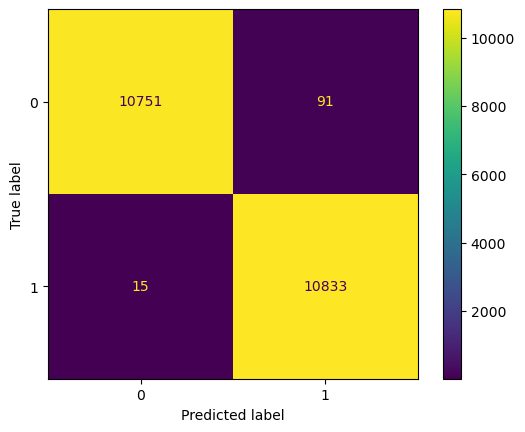

In [14]:
y_pred = ib_catb.predict(X_ib_validate)
print("CATB_IB")
print(classification_report(y_ib_validate, y_pred, digits=4))
print(classification_report(y_ib_validate, y_pred, digits=4), file=open("Outputs/CATB/"+MODEL_FILENAME+"_CATB_IB_ClassReport.txt", mode='w'))
disp = ConfusionMatrixDisplay(confusion_matrix(y_ib_validate, y_pred))
disp.plot()
plt.savefig("Outputs/CATB/"+MODEL_FILENAME+"_CATB_IB_"+"_ConfMatrix.png")

### 2.3.3. Preview of the Tree

*How can it be a tree if there is no proof of a tree?*

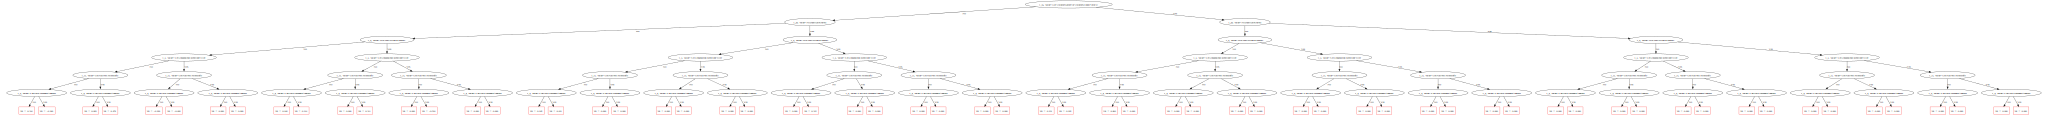

In [15]:
tree = ib_catb.plot_tree(0, catboost.Pool(X_ib_training, y_ib_training, cat_features=get_indexes(), feature_names=list(X_ib_training.columns)))
tree.save("Outputs/CATB/"+MODEL_FILENAME+"_CATB_TREE/IB_Tree"+".svg")
tree

In [16]:
logging("\n")